In [1]:
# Needed to import from model directory
import sys
sys.path.insert(0, '../model/')
 
# Importing the model
import mesa
import mesa_geo as mg
from agents import Person, Neighbourhood, House
from model import Housing

# Other imports
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
def collect_data(model, runs, steps):
    """
    Collects data from the model.

    Args:
        model (Housing): The model to collect data from.
        runs (int): The number of runs to collect data from.
        steps (int): The number of steps to collect data from.
    """

    # Create lists to store results
    results_local_price, results_local_contentment, results_global_price, results_global_contentment = [], [], [], []

    for r in tqdm(range(runs)):
        results_local_price.append([])
        results_local_contentment.append([])
        results_global_price.append([])
        results_global_contentment.append([])

        for s in range(steps):
            # Collect neighbourhood data
            neighbourhoods = model.get_agents(Neighbourhood)

            # Get average price and contentment for each neighbourhood
            local_prices = [{n.unique_id : n.average_house_price} for n in neighbourhoods]
            local_contentments = [{n.unique_id : n.average_contentment} for n in neighbourhoods]

            # Calculate average price and contentment for the whole city
            global_price = np.mean([d[list(d.keys())[0]] for d in local_prices])
            global_contentment = np.mean([d[list(d.keys())[0]] for d in local_contentments])

            # Append results
            results_local_price[r].append(local_prices)
            results_local_contentment[r].append(local_contentments)
            results_global_price[r].append(global_price)
            results_global_contentment[r].append(global_contentment)

            # Step the model
            model.step()
    
    return results_local_price, results_local_contentment, results_global_price, results_global_contentment

# Maybe write these outputs to a file?

In [9]:
def global_plots(results, steps, runs, title):    
    """
    Plots the global results.

    Args:
        results (list): The results to plot.
        steps (int): The number of steps to plot.
        runs (int): The number of runs to plot.
        title (str): The title of the plot.
    """
    
    # Initialize lists
    x = np.linspace(0, steps, steps)
    mean, variance, std_dev = [], [], []

    # Calculate mean, variance and standard deviation for each step
    for i in range(len(results[0])):
        data = [results[j][i] for j in range(len(results))]
        mean.append(np.mean(data))
        variance.append(np.var(data))
        std_dev.append(np.sqrt(np.var(data)))

    # Plot the results
    plt.plot(x, mean, 'k-', label='Mean')
    plt.fill_between(x, np.array(mean)-np.array(std_dev), np.array(mean)+np.array(std_dev), label='Standard deviation')

    plt.title(title)
    plt.xlabel('Step')
    plt.ylabel(" ".join(title.split()[:2]))

    plt.legend()
    plt.show()


## Experiment 1:

**RQ: What is the influence of an increase of avalible housing on the average house price of Amsterdam?**

Compare the the output of three different model initializations:
- Low housing growth rate
- Medium housing growth rate
- High housing growth rate

The other parameters will be initialized by their default values. 

100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


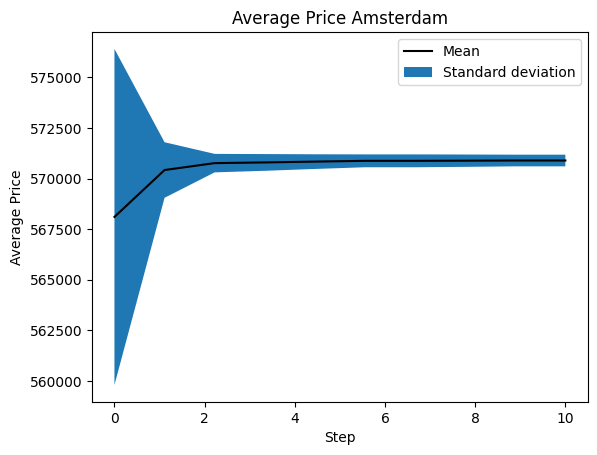

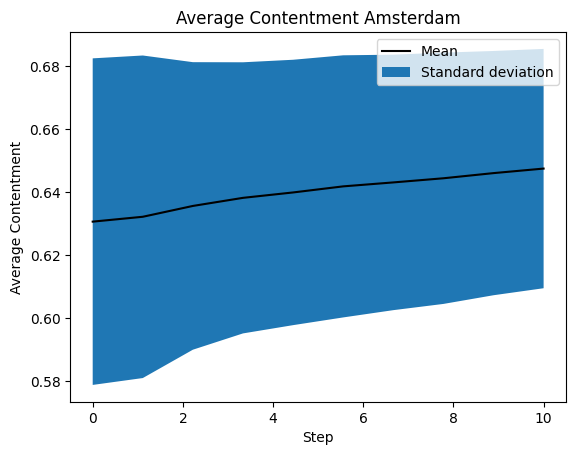

In [10]:
runs = 10
steps = 10

# Model with low housing growth rate (1.0)
model = Housing(num_houses=0.001, noise=0.0, start_money_multiplier=5, start_money_multiplier_newcomers=5, contentment_threshold=1, weight_materialistic=0.5, housing_growth_rate=1.0, population_growth_rate=1.01)
# Collect data
results_local_price, results_local_contentment, results_global_price, results_global_contentment = collect_data(model, runs, steps)

global_plots(results_global_price, steps, runs, "Average Price Amsterdam")
global_plots(results_global_contentment, steps, runs, "Average Contentment Amsterdam")

100%|██████████| 10/10 [00:16<00:00,  1.69s/it]


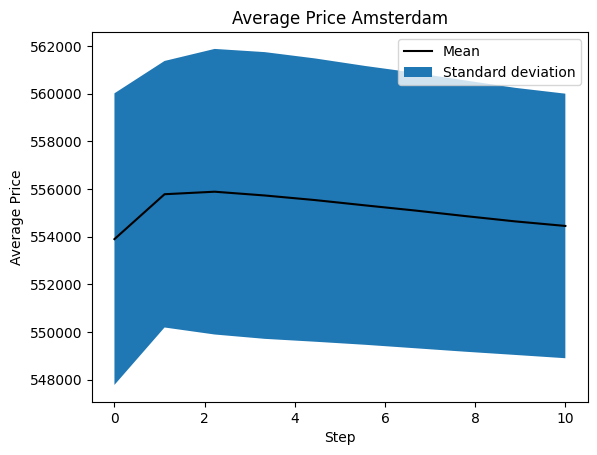

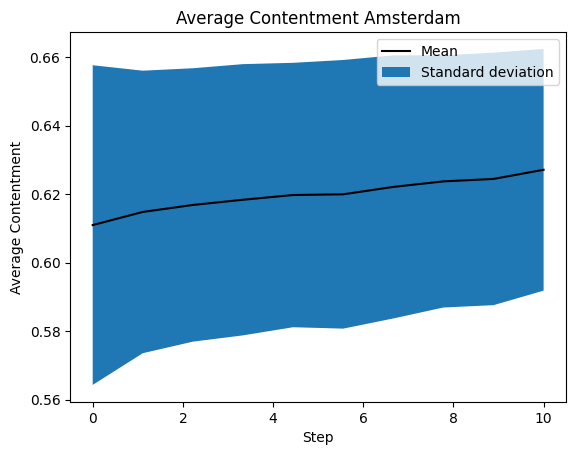

In [11]:
# Model with medium housing growth rate (1.025)
model = Housing(num_houses=0.001, noise=0.0, start_money_multiplier=5, start_money_multiplier_newcomers=5, contentment_threshold=1, weight_materialistic=0.5, housing_growth_rate=1.025, population_growth_rate=1.01)
# Collect data
results_local_price, results_local_contentment, results_global_price, results_global_contentment = collect_data(model, runs, steps)

global_plots(results_global_price, steps, runs, "Average Price Amsterdam")
global_plots(results_global_contentment, steps, runs, "Average Contentment Amsterdam")

100%|██████████| 10/10 [00:28<00:00,  2.85s/it]


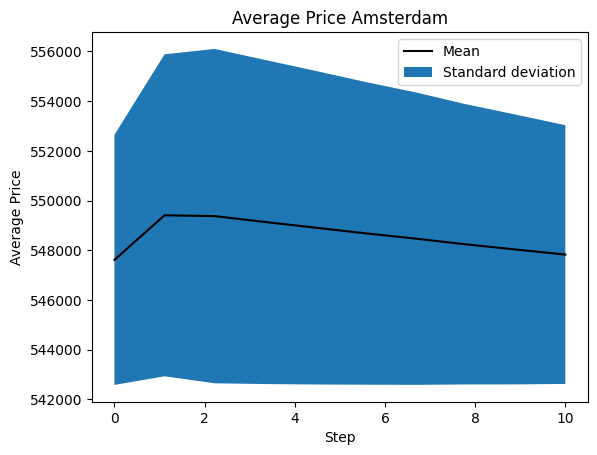

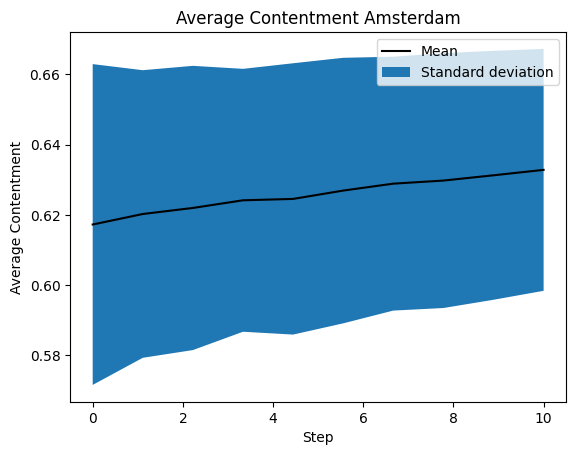

In [12]:
# Model with high housing growth rate (1.05)
model = Housing(num_houses=0.001, noise=0.0, start_money_multiplier=5, start_money_multiplier_newcomers=5, contentment_threshold=1, weight_materialistic=0.5, housing_growth_rate=1.05, population_growth_rate=1.01)
# Collect data
results_local_price, results_local_contentment, results_global_price, results_global_contentment = collect_data(model, runs, steps)

global_plots(results_global_price, steps, runs, "Average Price Amsterdam")
global_plots(results_global_contentment, steps, runs, "Average Contentment Amsterdam")